In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import os

# Star formation history


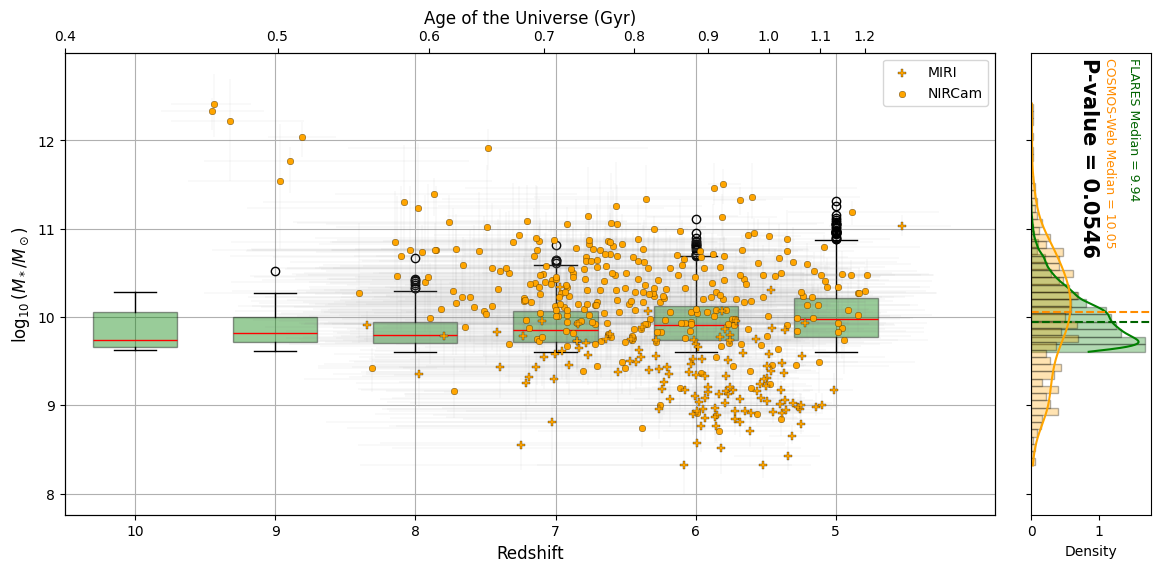

In [7]:
# Load the Akins data
akins_data = pd.read_csv('../data/LRD_data.csv')

# Convert relevant columns to float
akins_data['logMstar_med'] = akins_data['logMstar_med'].astype(float)
akins_data['logMstar_l68'] = akins_data['logMstar_l68'].astype(float)
akins_data['logMstar_u68'] = akins_data['logMstar_u68'].astype(float)
akins_data['z_gal_med'] = akins_data['z_gal_med'].astype(float)
akins_data['z_gal_l68'] = akins_data['z_gal_l68'].astype(float)
akins_data['z_gal_u68'] = akins_data['z_gal_u68'].astype(float)

# Set up the main plot and the secondary axis
fig, ax1 = plt.subplots(figsize=(12, 6))  # Main plot
ax2 = ax1.twiny()  # Secondary axis for age

# Load the FLARES data
flares_data = pd.read_csv('../data/filtered_FLARES_data.csv')
flares_data_grouped = flares_data.groupby('Redshift')['Stellar Mass']

# Boxplots for FLARES data
redshift_bins = list(range(5, 11))
flares_data_grouped_list = [flares_data_grouped.get_group(z) for z in redshift_bins if z in flares_data_grouped.groups]

boxprops = dict(facecolor='green', alpha=0.4)
medianprops = dict(color='red')

ax1.boxplot(flares_data_grouped_list, positions=redshift_bins, widths=0.6, patch_artist=True,
            boxprops=boxprops, medianprops=medianprops)

# Plot error bars for Akins data
ax1.errorbar(
    akins_data['z_gal_med'], 
    akins_data['logMstar_med'], 
    yerr=[akins_data['logMstar_med'] - akins_data['logMstar_l68'], akins_data['logMstar_u68'] - akins_data['logMstar_med']],
    xerr=[akins_data['z_gal_med'] - akins_data['z_gal_l68'], akins_data['z_gal_u68'] - akins_data['z_gal_med']],
    fmt='none', alpha=0.3, capsize=0, elinewidth=0.2, color='grey'
)

# Scatter plot for MIRI galaxies
miri_indices = akins_data['PB_MIRI'].astype(int) == 1
ax1.scatter(
    akins_data.loc[miri_indices, 'z_gal_med'],
    akins_data.loc[miri_indices, 'logMstar_med'],
    marker="P",
    s=26,
    label='MIRI',
    color='orange',
    alpha=1,
    edgecolors='black',
    linewidths=0.2,
    zorder=6
)

# Scatter plot for NIRCam galaxies
other_indices = ~miri_indices
ax1.scatter(
    akins_data.loc[other_indices, 'z_gal_med'],
    akins_data.loc[other_indices, 'logMstar_med'],
    marker="o",
    s=23,
    label='NIRCam',
    color='orange',
    alpha=1,
    edgecolors='black',
    linewidths=0.2,
    zorder=5
)

# Adding plot details
ax1.set_xlabel('Redshift', fontsize=12)
ax1.set_ylabel('$\\log_{10}(M_*/M_\\odot)$', fontsize=12)
ax1.legend()
ax1.grid(True)

# Define the age ticks in Gyr
age_ticks = np.arange(0.4, 1.3, 0.1)  # Age of the universe in Gyr

# Calculate corresponding redshift ticks for age ticks
redshift_ticks = [z_at_value(cosmo.age, age * u.Gyr) for age in age_ticks]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(redshift_ticks)
ax2.set_xticklabels([f'{age:.1f}' for age in age_ticks])
ax2.set_xlabel('Age of the Universe (Gyr)', fontsize=12)
ax1.invert_xaxis()
ax2.invert_xaxis()

# Create the density axis
divider = plt.gca().get_position().bounds
density_axis = fig.add_axes([divider[0] + divider[2] + 0.03, divider[1], 0.1, divider[3]], sharey=ax1)

# Probability density distribution for FLARES data
y_vals = np.linspace(min(flares_data['Stellar Mass']), max(flares_data['Stellar Mass']), 1000)
y_density_flares = gaussian_kde(flares_data['Stellar Mass'])(y_vals)
density_axis.hist(flares_data['Stellar Mass'], bins=20, density=True, color='green', alpha=0.3, orientation='horizontal', edgecolor='black')
density_axis.plot(y_density_flares, y_vals, color='green')
density_axis.axhline(np.median(flares_data['Stellar Mass']), color='darkgreen', linestyle='--')

# Probability density distribution for Akins data
y_vals_akins = np.linspace(akins_data['logMstar_med'].min(), akins_data['logMstar_med'].max(), 1000)
y_density_akins = gaussian_kde(akins_data['logMstar_med'])(y_vals_akins)
density_axis.hist(akins_data['logMstar_med'], bins=50, density=True, color='orange', alpha=0.3, orientation='horizontal', edgecolor='black')
density_axis.plot(y_density_akins, y_vals_akins, color='orange')
density_axis.axhline(np.median(akins_data['logMstar_med']), color='darkorange', linestyle='--')

# Add density plot details
density_axis.set_xlabel('Density', fontsize=10)
density_axis.yaxis.set_tick_params(labelleft=False)

# Add text annotations
density_axis.text(0.6, 0.99, f'COSMOS-Web Median = {np.median(akins_data["logMstar_med"]):.2f}', 
                  transform=density_axis.transAxes, color='darkorange', fontsize=9, verticalalignment='top', rotation=-90)
density_axis.text(0.8, 0.99, f'FLARES Median = {np.median(flares_data["Stellar Mass"]):.2f}', 
                  transform=density_axis.transAxes, color='darkgreen', fontsize=9, verticalalignment='top', rotation=-90)
density_axis.text(0.4, 0.99, f'', transform=density_axis.transAxes, 
                  color='black', fontsize=15, verticalalignment='top', rotation=-90, fontweight='bold')

plt.show()



# Stellar mass distributions per redhift bin


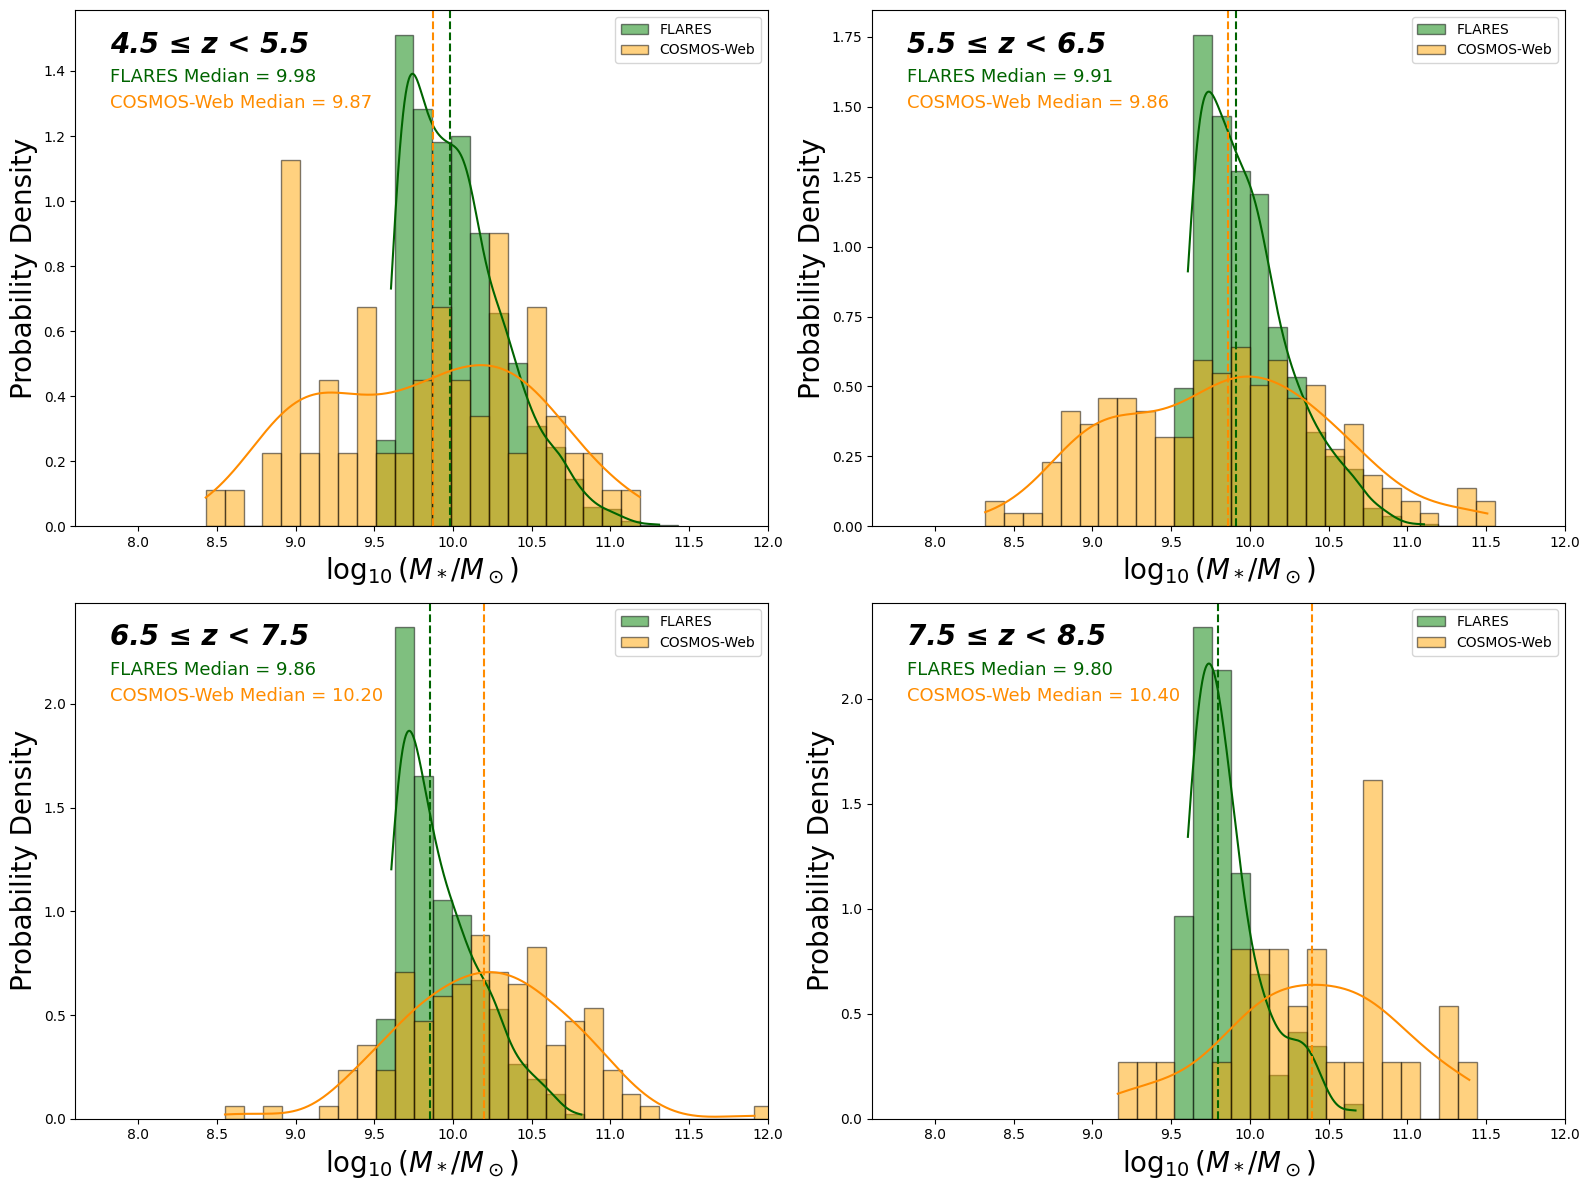

In [8]:
# Define redshift bins
bins = np.arange(4.5, 8.6, 1.0)  # From 4.5 to 8.5 in steps of 1.0, creating four bins

# Desired bin width for histograms
bin_width = 0.12  # Specify the bin width

# Set up the main plot with the appropriate number of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted for four plots (2 rows, 2 columns)
axes = axes.flatten()

# Loop through each bin and create plots
for i in range(len(bins) - 1):
    ax = axes[i]
    lower = bins[i]
    upper = bins[i + 1]

    # Filter the datasets for each bin
    filtered_akins = akins_data[(akins_data['z_gal_med'] >= lower) & (akins_data['z_gal_med'] < upper)]
    filtered_flares = flares_data[(flares_data['Redshift'] >= lower) & (flares_data['Redshift'] < upper)]

    # Determine shared bin edges based on combined data and desired bin width
    min_bin = min(filtered_flares['Stellar Mass'].min(), filtered_akins['logMstar_med'].min())
    max_bin = max(filtered_flares['Stellar Mass'].max(), filtered_akins['logMstar_med'].max())
    bin_edges = np.arange(min_bin, max_bin + bin_width, bin_width)

    # Plot histogram and KDE for FLARES data if available
    if not filtered_flares.empty:
        ax.hist(filtered_flares['Stellar Mass'], bins=bin_edges, density=True, alpha=0.5, color='green', edgecolor='black', label='FLARES')
        green_density = gaussian_kde(filtered_flares['Stellar Mass'], bw_method='silverman')
        y_vals = np.linspace(filtered_flares['Stellar Mass'].min(), filtered_flares['Stellar Mass'].max(), 1000)
        ax.plot(y_vals, green_density(y_vals), color='darkgreen')
        median_flares = np.median(filtered_flares['Stellar Mass'])
        ax.axvline(median_flares, color='darkgreen', linestyle='--')
        
        # Add green text for the median value
        ax.text(0.05, 0.86, f'FLARES Median = {median_flares:.2f}', color='darkgreen', fontsize=13, ha='left', transform=ax.transAxes)

    # Plot histogram and KDE for Akins data if available
    if not filtered_akins.empty:
        ax.hist(filtered_akins['logMstar_med'], bins=bin_edges, density=True, alpha=0.5, color='orange', edgecolor='black', label='COSMOS-Web')
        orange_density = gaussian_kde(filtered_akins['logMstar_med'], bw_method='silverman')
        y_vals_orange = np.linspace(filtered_akins['logMstar_med'].min(), filtered_akins['logMstar_med'].max(), 1000)
        ax.plot(y_vals_orange, orange_density(y_vals_orange), color='darkorange')
        median_akins = np.median(filtered_akins['logMstar_med'])
        ax.axvline(median_akins, color='darkorange', linestyle='--')
        
        # Add orange text for the median value
        ax.text(0.05, 0.81, f'COSMOS-Web Median = {median_akins:.2f}', color='darkorange', fontsize=13, ha='left', transform=ax.transAxes)

    # Set axes properties
    ax.set_xlabel('$\\log_{10}(M_*/M_\\odot)$', fontsize=20)
    ax.set_ylabel('Probability Density', fontsize=20)
    ax.text(0.05, 0.96, f'{lower} \u2264 z < {upper}', transform=ax.transAxes, verticalalignment='top', fontdict={'fontsize': 20, 'fontstyle': 'italic', 'fontweight': 'bold'})
    ax.set_xlim(7.6, 12)  # Set x-limits based on the bin edges
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Ensure the 'plots' directory exists
os.makedirs('plots', exist_ok=True)

# Show the plot
plt.show()

